In [1]:
# Minimal VGG16 transfer learning (compact & exam-ready)
import numpy as np, matplotlib.pyplot as plt, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# -------------------- USER CONFIG --------------------
DATA_DIR = "caltech101"   # root folder with class subfolders (one folder per class)
WEIGHTS_PATH = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
TARGET_SIZE = (224,224)
BATCH = 32
EPOCHS_HEAD = 6
LR_HEAD = 1e-3
selected_classes = ['airplanes','ant']   # set None to use all classes
# -----------------------------------------------------

In [3]:
# quick device info
print("TF version:", tf.__version__, "| GPU available:", bool(tf.config.list_physical_devices("GPU")))

# 1) Data generators (train/val from same folder using validation_split)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True, 
                                   rotation_range=15, 
                                   zoom_range=0.1,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR, 
    target_size=TARGET_SIZE, 
    batch_size=BATCH,
    classes=selected_classes, 
    subset='training', 
    class_mode='categorical', 
    shuffle=True, 
    seed=42
)
val_gen = train_datagen.flow_from_directory(
    DATA_DIR, 
    target_size=TARGET_SIZE, 
    batch_size=BATCH,
    classes=selected_classes, 
    subset='validation', 
    class_mode='categorical', 
    shuffle=False, seed=42
)

num_classes = train_gen.num_classes
print("Num classes:", num_classes, 
      "Train samples:", train_gen.samples, 
      "Val samples:", val_gen.samples)

TF version: 2.20.0 | GPU available: False
Found 674 images belonging to 2 classes.
Found 168 images belonging to 2 classes.
Num classes: 2 Train samples: 674 Val samples: 168


In [4]:
# 2) Load VGG16 base (no top) and load provided weights, freeze base
base = VGG16(
    include_top=False, 
    weights=None, 
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

base.load_weights(WEIGHTS_PATH)
for layer in base.layers:
    layer.trainable = False

In [5]:
# 3) Build small classifier head
model = keras.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(LR_HEAD), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,912,322 (56.89 MB)

 Trainable params: 197,634 (772.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# 4) Train only the head with EarlyStopping
es = EarlyStopping(monitor='val_accuracy', 
                   patience=2, 
                   restore_best_weights=True, 
                   verbose=1)

history = model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=EPOCHS_HEAD, 
    callbacks=[es], 
    verbose=2
)

C:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
22/22 - 248s - 11s/step - accuracy: 0.9228 - loss: 0.8087 - val_accuracy: 0.9405 - val_loss: 0.3134
Epoch 2/6
22/22 - 217s - 10s/step - accuracy: 0.9941 - loss: 0.0227 - val_accuracy: 0.9940 - val_loss: 0.0095
Epoch 3/6
22/22 - 190s - 9s/step - accuracy: 0.9970 - loss: 0.0067 - val_accuracy: 0.9702 - val_loss: 0.2490
Epoch 4/6
22/22 - 199s - 9s/step - accuracy: 0.9970 - loss: 0.0139 - val_accuracy: 0.9881 - val_loss: 0.0918
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [7]:
# 5) Evaluate
loss, acc = model.evaluate(val_gen, verbose=0)
print(f"\nValidation loss: {loss:.4f} | Validation accuracy: {acc:.4f}")


Validation loss: 0.0275 | Validation accuracy: 0.9881


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


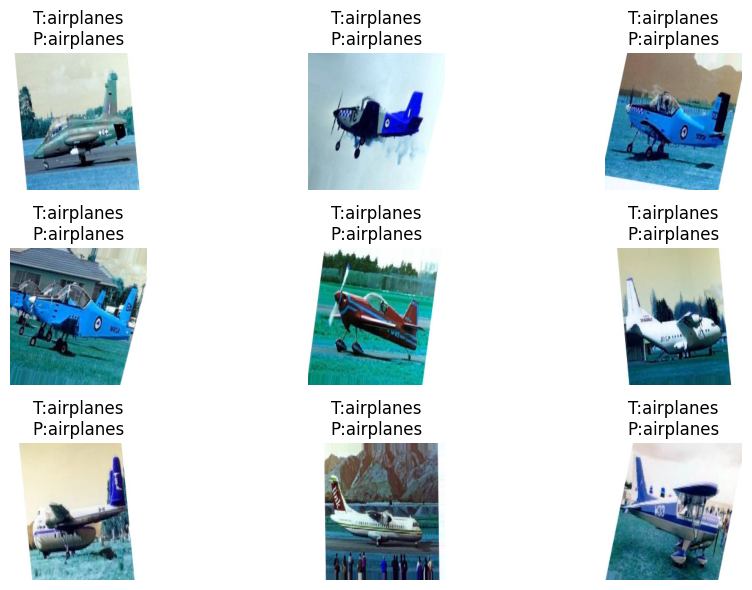

In [8]:
# 6) Show a few validation images + predictions
imgs, labels = next(val_gen)
preds = np.argmax(model.predict(imgs), axis=1)
true = np.argmax(labels, axis=1)
inv = {v:k for k,v in train_gen.class_indices.items()}

plt.figure(figsize=(10,6))
for i in range(min(9, imgs.shape[0])):
    ax = plt.subplot(3,3,i+1)
    # images are preprocessed; convert back for display roughly
    img = imgs[i]
    img = (img + [103.939, 116.779, 123.68]) / 255.0
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"T:{inv[true[i]]}\nP:{inv[preds[i]]}")
    plt.axis('off')
plt.tight_layout(); plt.show()

In [9]:
# 7) (Optional) Fine-tune: unfreeze last N base layers then recompile and train with smaller LR
N = 4
for layer in base.layers[-N:]: layer.trainable = True
    
model.compile(
    optimizer=Adam(1e-4),           
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=3, 
    callbacks=[es], 
    verbose=2
)

Epoch 1/3
22/22 - 241s - 11s/step - accuracy: 0.9896 - loss: 0.0463 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 2/3
22/22 - 218s - 10s/step - accuracy: 0.9985 - loss: 0.0027 - val_accuracy: 0.9940 - val_loss: 0.0310
Epoch 3/3
22/22 - 221s - 10s/step - accuracy: 0.9941 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [10]:
# 8) Evaluate
loss, acc = model.evaluate(val_gen, verbose=0)
print(f"\nValidation loss: {loss:.4f} | Validation accuracy: {acc:.4f}")


Validation loss: 0.0144 | Validation accuracy: 0.9881
